In [1]:
# %matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

from astropy.io import fits
from IPython.display import HTML
from hcipy import *

import sys
sys.path.append('/home/jasper/Documents/HCIPy_scripts/magaox-iefc-sim/')

from magsimpyx import make_magaox_bump_mask

from iefc_utils import *

plt.style.use('spieposter')

In [2]:
# Set units

pupil_diameter = 6.5
wavelength = 750e-9 # m
effective_focal_length = 1

spatial_resolution = wavelength / pupil_diameter
sr = spatial_resolution


pupil_grid = make_pupil_grid(256, diameter=1.2*pupil_diameter)    # Pad the grid to offer a bit more room

uniform_grid = make_uniform_grid([256, 256, 100], extent=[1.2*pupil_diameter, 1.2*pupil_diameter, 10]).shifted([0, 0, 10])


focal_grid = make_focal_grid(q=5, num_airy=25, spatial_resolution = wavelength/pupil_diameter)

# focal_grid = make_focal_grid(q=4, num_airy=16, spatial_resolution = wavelength/pupil_diameter)


prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=effective_focal_length)

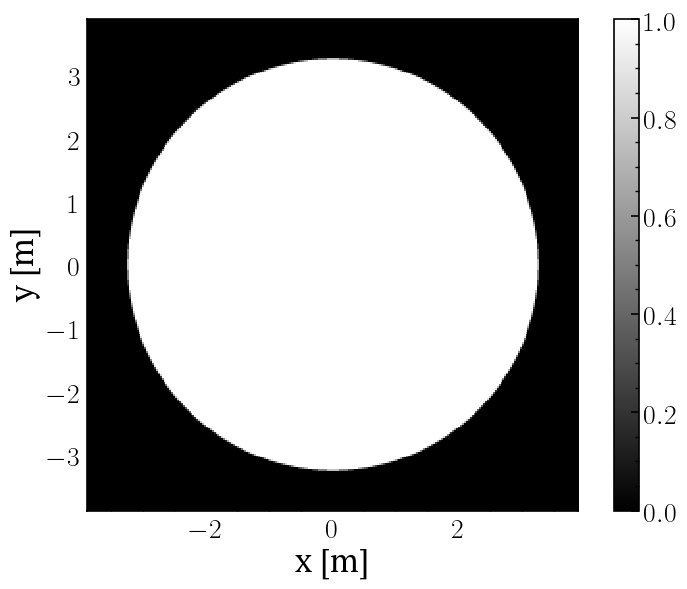

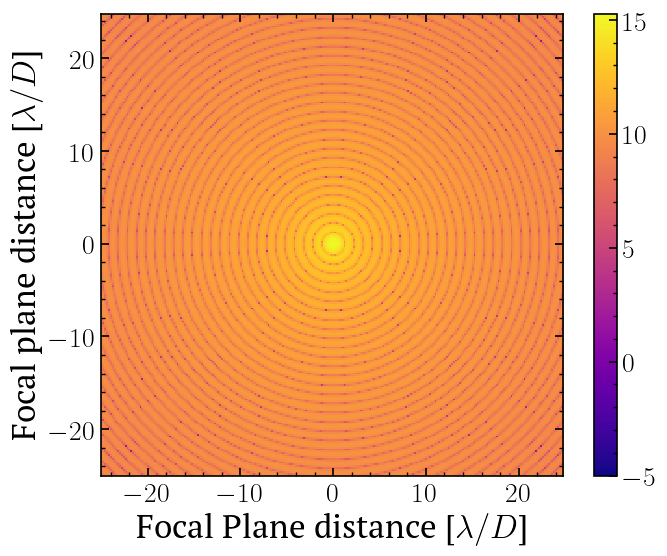

In [3]:
telescope_pupil_circ = evaluate_supersampled(make_circular_aperture(pupil_diameter), pupil_grid, 4)

# Plot telescope  pupil
imshow_field(telescope_pupil_circ, cmap='gray',)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.tight_layout()
# plt.savefig('../mag_ap.svg', transparent=True)
plt.show()

wavefront = Wavefront(telescope_pupil_circ, wavelength)

wavefront.total_power = 1

focal_image = prop.forward(wavefront)

norm = focal_image.power.max()

# Plot PSF
imshow_field(np.log10(focal_image.intensity / norm), vmin=-5, grid_units=sr)
# save_field('magellan_pup.svg', np.log10(focal_image.intensity / norm))
plt.xlabel('Focal Plane distance [$\lambda / D$]')
plt.ylabel('Focal plane distance [$\lambda / D$]')
plt.colorbar()
plt.show()

In [4]:
######## Initialize Lyot stop + vortex CG
center_pos = np.array([0*pupil_diameter, 0]) # Pupil plane shift is defined in percentage of the pupil
lyot_mask = evaluate_supersampled(make_circular_aperture(0.95*pupil_diameter), pupil_grid, 4) # Generate undersized Lyot stop

# Note: This should be opaque!
# focal_plane_mask = 1 - evaluate_supersampled(make_circular_aperture(6*sr), coro_focal_grid, 4) # Define FPM w/ diameter of 6 lambda/D and oversampled CG grid

lyot_stop = Apodizer(lyot_mask)

# Generate a Lyot CG on the oversample CG grid
# order = 2
# coro_lyot = LyotCoronagraph(pupil_grid, focal_plane_mask, lyot_stop,  focal_plane_mask_grid=coro_focal_grid)


############ Initialize Vortex CG
# charge = 6                      # Generate a charge 6 Vortex CG
# coro_vortex = VectorVortexCoronagraph(charge=charge, lyot_stop=None)
charge = 4
coro_vortex = VortexCoronagraph(pupil_grid, charge=charge)

In [5]:
#  Construct 1k DM
num_actuators_across_pupil = 34
actuator_spacing = pupil_diameter / num_actuators_across_pupil
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing, x_tilt=np.rad2deg(45))
deformable_mirror = DeformableMirror(influence_functions)
num_modes = deformable_mirror.num_actuators

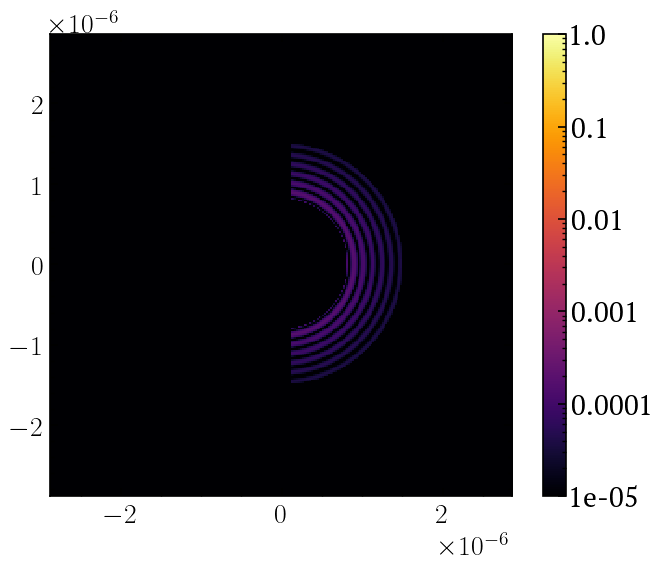

In [6]:


# Define control region

Dtel = 6.5
fourier_grid = make_pupil_grid(32, 32)        # Define grid


# fourier_mask = (fourier_grid.as_('polar').r < 10) * (fourier_grid.as_('polar').r > 2)   # Overlay modes from 2-10 lambda/d
# fourier_mask *= fourier_grid.x > 0

# focal_mask = (focal_grid.as_('polar').r < 9*sr) * (focal_grid.as_('polar').r > 3*sr)    # We prev. defined as 1 lambda/D
# focal_mask *= focal_grid.x > 1*sr

wavefront_circ = Wavefront(telescope_pupil_circ, wavelength)

wavefront_circ.total_power = 1

# focal_image = prop.forward(wavefront)

 # fourier_mask = (fourier_grid.as_('polar').r < 14) * (fourier_grid.as_('polar').r > 6)   #  Overlay modes from 6-14 lambda/d


fourier_mask = (fourier_grid.as_('polar').r < 14) * (fourier_grid.as_('polar').r > 6)   
fourier_mask *= fourier_grid.x > 0

# focal_mask = (focal_grid.as_('polar').r < 13*sr) * (focal_grid.as_('polar').r > 7*sr) 


focal_mask = (focal_grid.as_('polar').r < 13*sr) * (focal_grid.as_('polar').r > 7*sr) 

focal_mask *= focal_grid.x > 1*sr

focal_image_circ = prop.forward(wavefront_circ)

dark_hole_pixels_circ = focal_image_circ.power*focal_mask



imshow_psf(dark_hole_pixels_circ/focal_image_circ.power.max() + 1e-16, vmax=1, vmin=1e-5)
plt.show()

fourier_basis = make_fourier_basis(pupil_grid, fourier_grid.scaled(2 * np.pi / Dtel))   

# Select Fourier modes that fall within DH
selected_modes = fourier_grid.subset(fourier_mask>0)     

# Select Fourier modes that fall within DH
fourier_basis_selected = make_fourier_basis(pupil_grid, selected_modes.scaled(2 * np.pi / Dtel))   # Basis w/ seelected Fourier modes from control region

fourier_dm = DeformableMirror(fourier_basis)
fourier_dm_selected = DeformableMirror(fourier_basis_selected)  # Create DM w/ only the selected modesw from control region

In [7]:
fourier_dm_selected.num_actuators

504

In [8]:
# Initialize vars for Jacobian

# optical_system_vortex = OpticalSystem([coro_vortex,lyot_stop, prop])
# wf_vortex = Wavefront(telescope_pupil_circ, wavelength)
# wf_vortex.total_power = 1

# optical_system_perfect = OpticalSystem([coro_perfect, prop])
# wf_perfect = Wavefront(telescope_pupil_mag, wavelength)
# wf_perfect.total_power = 1

# optical_system_lyot = OpticalSystem([coro_lyot, lyot_stop, prop])
# wf_lyot = wf_perfect.copy()

# Initialize vars for Jacobian

optical_system_lyot = OpticalSystem([coro_vortex, lyot_stop, prop])

wf_vortex = Wavefront(telescope_pupil_circ, wavelength)

wf_vortex.total_power = 1 # Always define power, normalize it to 1


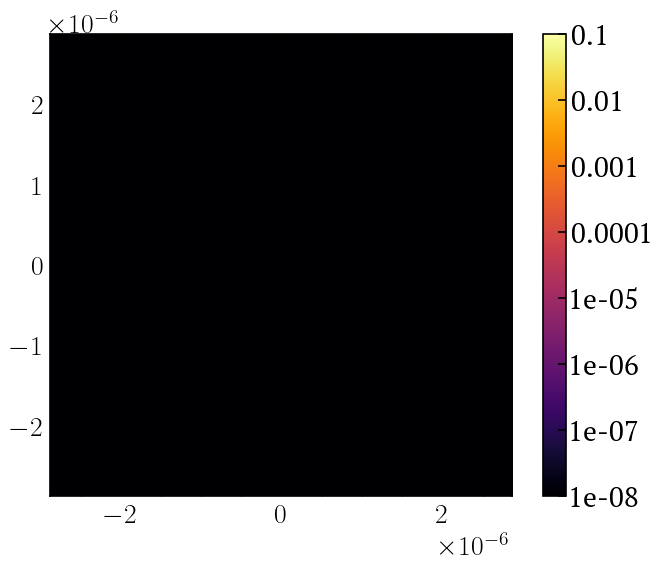

In [9]:
imshow_psf(optical_system_lyot(wf_vortex))

In [10]:

# coro_list = [coro_perfect, coro_lyot, coro_vortex]    # Debugging

coro_list = [coro_vortex]

    # # Jacobian (iEFC)

    ######## NEW GITHUB VERSION ##########################

probe_amp = 0.01 * wavelength # Set a probe amplitude
calibration_amp = 0.01 * wavelength


# wf = Wavefront(telescope_pupil, wavelength) # Reference WF

num_modes = fourier_dm_selected.num_actuators # Excite only the modes that fall within control region

# response_matrices_selected = np.zeros(((len(coro_list), num_modes, 3708))) # Initialize empty vector of slopes

response_matrices_selected = np.zeros(((len(coro_list), num_modes, 8848))) # Initialize empty vector of slopes



amps = np.ones(num_modes) * probe_amp

deformable_mirror.flatten()
fourier_dm_selected.flatten()

for coro_idx, coro in enumerate(coro_list):
    if coro == (coro_vortex or coro_lyot):
        optical_system = OpticalSystem([coro, lyot_stop, prop])
    else:
        optical_system = OpticalSystem([coro, prop])

    if coro == coro_vortex:
        wf = Wavefront(telescope_pupil_circ, wavelength) # Reference WF
        wf.total_power = 1
    else:
        wf = Wavefront(telescope_pupil_mag, wavelength)
        wf.total_power = 1

    pwp_sensor = make_pairwise_probing_sensor(probe_1=400, probe_2=401, probe_amp=0.01*wavelength, dm=deformable_mirror, optical_system=optical_system)

    print(coro)
    for ind in range(num_modes):
        if ind % 10 == 0:
            print('Measure response to mode {:d} / {:d}'.format(ind + 1, num_modes))
        
        calibration_images = []
        for cal_amp in [-calibration_amp, calibration_amp]:

            # Add the mode that we are calibrating
            fourier_dm_selected.actuators[ind] += cal_amp #  (Fourier DM) Ensure that we are only calibrating modes that fall on the pupil

            diff_images = pwp_sensor(fourier_dm_selected(wf))  # Perform PWP

            # diff_images = pwp_sensor(coro(fourier_dm_selected(wf)))  # Perform PWP


            if coro == coro_vortex:
                pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels_circ>0) # Extract diff image measurements for DH region
            else:
                pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels_mag>0) # Extract diff image measurements for DH region
            
            calibration_images.append(pwp_measurement)

            # Remove the mode that we are calibrating
            fourier_dm_selected.actuators[ind] -= cal_amp

        slope =  ((calibration_images[1] - calibration_images[0])/(2*calibration_amp)) # Construct slope vector

        response_matrices_selected[coro_idx][ind] = slope
        # response_matrices_selected.append(slope) # Append slope vector to response matrix

response_matrices_selected_arr = np.array(response_matrices_selected)


Measure response to mode 1 / 504
Measure response to mode 11 / 504
Measure response to mode 21 / 504
Measure response to mode 31 / 504
Measure response to mode 41 / 504
Measure response to mode 51 / 504
Measure response to mode 61 / 504
Measure response to mode 71 / 504
Measure response to mode 81 / 504
Measure response to mode 91 / 504
Measure response to mode 101 / 504
Measure response to mode 111 / 504
Measure response to mode 121 / 504
Measure response to mode 131 / 504
Measure response to mode 141 / 504
Measure response to mode 151 / 504
Measure response to mode 161 / 504
Measure response to mode 171 / 504
Measure response to mode 181 / 504
Measure response to mode 191 / 504
Measure response to mode 201 / 504
Measure response to mode 211 / 504
Measure response to mode 221 / 504
Measure response to mode 231 / 504
Measure response to mode 241 / 504
Measure response to mode 251 / 504
Measure response to mode 261 / 504
Measure response to mode 271 / 504
Measure response to mode 281 / 

In [11]:
# np.save('./jacobian_twoCGs_scoob_sim.npy', response_matrices_selected_arr)
np.save('./jacobian_pwp_circ_ap_7_13.npy', response_matrices_selected_arr)


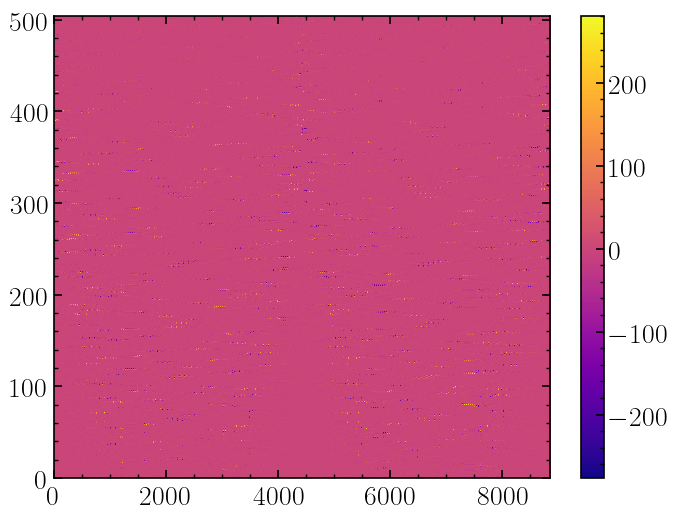

In [12]:
num_modes = fourier_dm_selected.num_actuators # Excite only the modes that fall within control region


# Load Jacobian
# coro_list = [coro_perfect, coro_lyot, coro_vortex]
coro_list = [coro_vortex]


# coro_list = [coro_vortex]
resp_mat_sel = response_matrices_selected_arr

plt.imshow(response_matrices_selected[0], aspect='auto')
plt.colorbar()
plt.show()

# Compute reconstruction matrix
# rcond = 2e-3
rcond = 1e-2

# reconstruction_matrices_selected = np.zeros(((len(coro_list), num_modes, 3708))) # Initialize empty vector of reconstruction matrices

reconstruction_matrices_selected = np.zeros(((len(coro_list), num_modes, 8848))) # Initialize empty vector of reconstruction matrices


resp_mat_sel.shape

reconstruction_matrices_selected.shape

for idx, resp in enumerate(resp_mat_sel): 
    reconstruction_matrices_selected[idx] = inverse_tikhonov(resp.T, rcond=rcond, svd=None) # Feed in response matrix for DH modes


# reconstruction_matrices_selected = inverse_tikhonov(resp_mat_sel.T, rcond=rcond, svd=None) # Feed in response matrix for DH modes

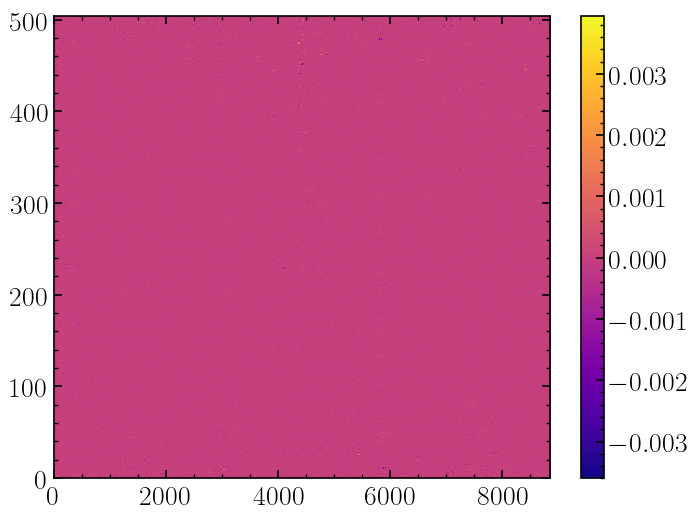

In [13]:
plt.imshow(reconstruction_matrices_selected[0], aspect='auto')
plt.colorbar()
plt.show()

In [14]:
# np.save('./rec_mat_twoCGs_scoob_sim.npy', reconstruction_matrices_selected)
np.save(f'./rec_mat_pwp_svc_circ_ap_7_13_reg_{rcond}.npy', reconstruction_matrices_selected)



In [19]:
# plt.imshow(response_matrices_selected[0], aspect='auto')
